In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import os
import ast
import torch
import pickle
import keyboard
import numpy as np
import pandas as pd
from utils.env_utils import *
from utils.eval_utils import *
import matplotlib.pyplot as plt
from utils.train_utils import *
from utils.couzin_utils import *
import matplotlib.image as mpimg
import matplotlib.colors as colors
from marl_aquarium import aquarium_v0
from models.Buffer import Pool, Buffer
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
gail_folder = "GAIL Training - 19.11.2025_18.52 - Couzin Data"
bc_folder = "BC Training - 19.11.2025_18.52 - Couzin Data"

model_folder = rf"..\data\2. Training\training"
gail_path = os.path.join(model_folder, "GAIL", gail_folder)
bc_path = os.path.join(model_folder, "BC", bc_folder)

expert_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected\expert_metrics_yd.pkl'
ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model Comparison using Swarm Metrics

In [3]:
start_frame_pool = Pool(max_length=12100, device=device)
start_frame_pool.generate_startframes(ftw_path)

env = parallel_env(predator_count=1, prey_count=32, action_count=360, use_walls=True)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
print("Environment initialized")

Environment initialized


In [4]:
num_steps = 1000

# GAIL Simulation
gail_pred_policy = torch.load(os.path.join(gail_path, "gail_pred_policy.pt"), weights_only=False)
gail_prey_policy = torch.load(os.path.join(gail_path, "gail_prey_policy.pt"), weights_only=False)
gail_metrics = run_policies_in_steps(env, gail_pred_policy, gail_prey_policy, steps=num_steps, render=False)
print("GAIL Simulation done!")

# BC Simulation
bc_pred_policy = torch.load(os.path.join(bc_path, "bc_pred_policy.pt"), weights_only=False)
bc_prey_policy = torch.load(os.path.join(bc_path, "bc_prey_policy.pt"), weights_only=False)
bc_metrics = run_policies_in_steps(env, bc_pred_policy, bc_prey_policy, steps=num_steps, render=False)
print("BC Simulation done!")

# Couzin Simulation
couzin_pred_tensor, couzin_prey_tensor, couzin_metrics = run_couzin_simulation(visualization="off", max_steps=num_steps)
print("Couzin Simulation done!")

# Load Expert Data
with open(expert_path, "rb") as f:
    expert_data = pickle.load(f)
expert_metrics = compute_expert_metrics(expert_data, 33)
print("Expert Metrics computed!")

GAIL Simulation done!
BC Simulation done!
Couzin Simulation done!
Expert Metrics computed!


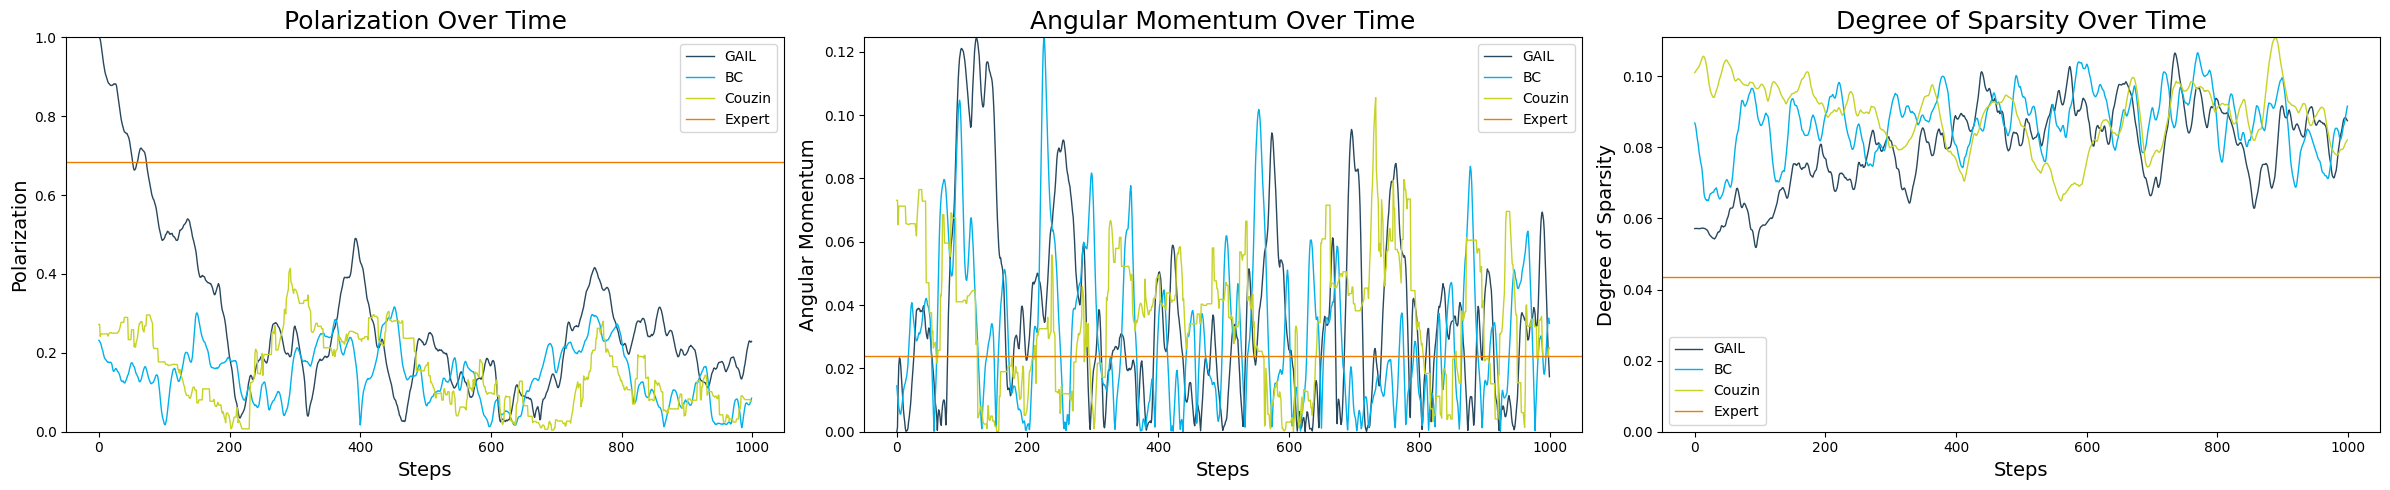

In [5]:
plot_swarm_metrics(gail_metrics, bc_metrics, couzin_metrics, expert_metrics)

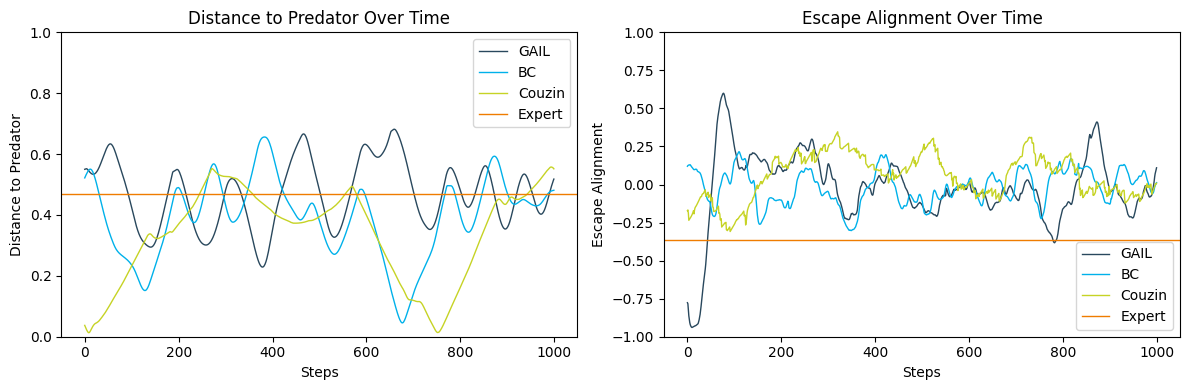

In [6]:
plot_pred_prey_metrics(gail_metrics, bc_metrics, couzin_metrics, expert_metrics)

## Analysis of Modular Networks

In [3]:
gail_pred_policy = torch.load(os.path.join(gail_path, "gail_pred_policy.pt"), weights_only=False)
gail_prey_policy = torch.load(os.path.join(gail_path, "gail_prey_policy.pt"), weights_only=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
pred_img_path = rf"..\data\3. Evaluation\images\predator.png"
prey_img_path = rf"..\data\3. Evaluation\images\prey.png"

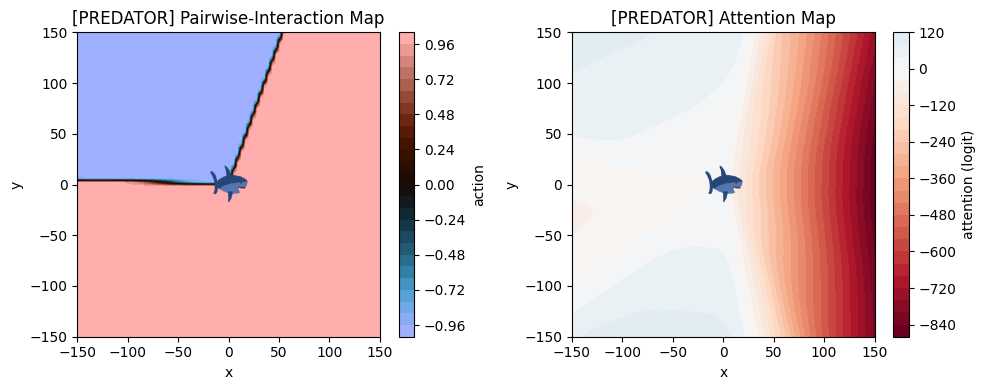

In [4]:
xs, ys, pred_action_map, pred_attn_map = compute_pin_an_maps(pin = gail_pred_policy.pairwise,
                                                             an = gail_pred_policy.attention,
                                                             role = "predator",
                                                             v=1.0,
                                                             x_range=(-150, 150),
                                                             y_range=(-150, 150),
                                                             n_points=80,
                                                             n_orient=72,
                                                             device=device)

plot_policy_maps(xs, ys, pred_action_map, pred_attn_map, role="predator", img_path=pred_img_path)

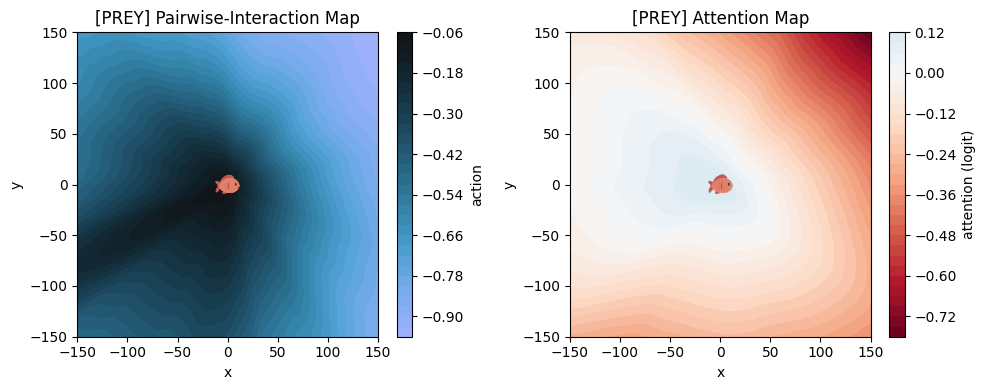

In [5]:
xs, ys, prey_action_map, prey_attn_map = compute_pin_an_maps(pin = gail_prey_policy.prey_pairwise,
                                                             an = gail_prey_policy.prey_attention,
                                                             role = "prey",
                                                             v=1.0,
                                                             x_range=(-150, 150),
                                                             y_range=(-150, 150),
                                                             n_points=80,
                                                             n_orient=72,
                                                             device=device)

plot_policy_maps(xs, ys, prey_action_map, prey_attn_map, role="prey", img_path=prey_img_path)

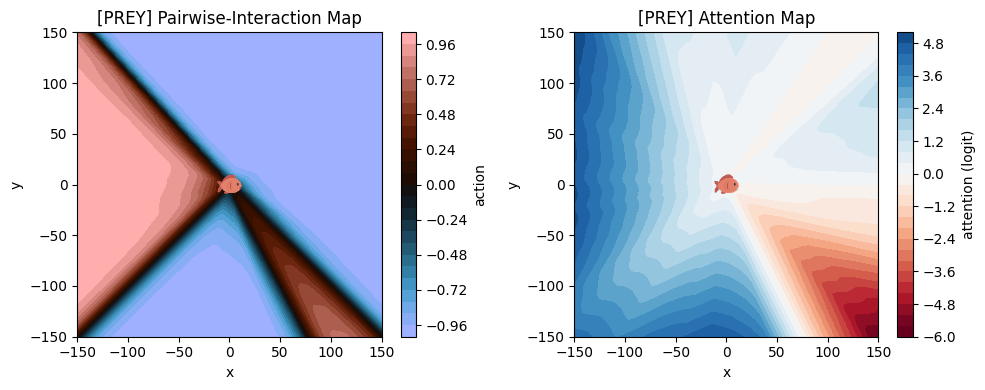

In [6]:
xs, ys, prey_action_map, prey_attn_map = compute_pin_an_maps(pin = gail_prey_policy.pred_pairwise,
                                                             an = gail_prey_policy.pred_attention,
                                                             role = "prey",
                                                             v=1.0,
                                                             x_range=(-150, 150),
                                                             y_range=(-150, 150),
                                                             n_points=80,
                                                             n_orient=72,
                                                             device=device)

plot_policy_maps(xs, ys, prey_action_map, prey_attn_map, role="prey", img_path=prey_img_path)